## Implementation of an object detector 
In this notebook, you will need to implement an CNN based object detector to detect specific objects in given images.

You will find the resources in folder 'src'. It contains the image set for training and testing, the groundtruth of the images, and a folder to place your parameters (weights).

<img src="pics/0__1_.jpg" alt="Biker" />

This task is divided into three sections. This notebook contains only the first section. 

- In the first section, you will load weights to a pre-defined neural network


In [1]:
from __future__ import absolute_import, division, print_function

import os
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
tf.logging.set_verbosity(tf.logging.INFO)
print(tf.__version__)
print(tf.keras.__version__)

import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from PIL import Image, ImageDraw

1.14.0
2.2.4-tf


Check the devices available on your machine:

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11174560636172730789
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3146173644
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16769046251830911259
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


Before we do anything, we need to import the image data.

In [3]:
'''
Load groundtruch
'''
import json
with open('src/groundtruth.txt', 'r') as file:
    lines = json.load(file)

print('There are %d image-label pair in the entire set' %(len(lines)))
print('First entry looks like this:')
print(lines[0])

There are 996 image-label pair in the entire set
First entry looks like this:
['src/images/932.jpg', [0.48984375, 0.5055555555555555, 0.0328125, 0.08333333333333333]]


Now, we need to pick ramdomly from the data set to put aside a subset of images for testing. The model **should not** see this subset of images while training.

In [4]:
'''
This function converts the image into the input type.
'''
def load_input(path):
    img = Image.open(path)
    img = img.resize((320,160))
    input_img = np.asarray(img).astype(np.float32)
    input_img = (input_img/255 - 0.5)/0.25
    return input_img[np.newaxis,:]

'''
This function draws the rectangle around the object
'''
def show_image(image, box):
    img = Image.open(image)
    
    box_top_left = (int((box[0] - box[2]/2)*640), int((box[1] + box[3]/2)*360))
    box_bot_right = (int((box[0] + box[2]/2)*640), int((box[1] - box[3]/2)*360))

    draw = ImageDraw.ImageDraw(img)
    draw.rectangle((box_top_left, box_bot_right), outline = (255,0,0))

    plt.figure(1, figsize = (16, 9), dpi =300)
    plt.imshow(img)
    plt.show()

There are 96 image-label pair in the testing set
There are 900 image-label pair in the training set
First image in the testing set is: src/images/664.jpg
Corresponding box is: [0.15625, 0.6319444444444444, 0.053125, 0.175]
First image in the training set is: src/images/933.jpg
Corresponding box is: [0.621875, 0.5902777777777778, 0.06875, 0.10277777777777777]


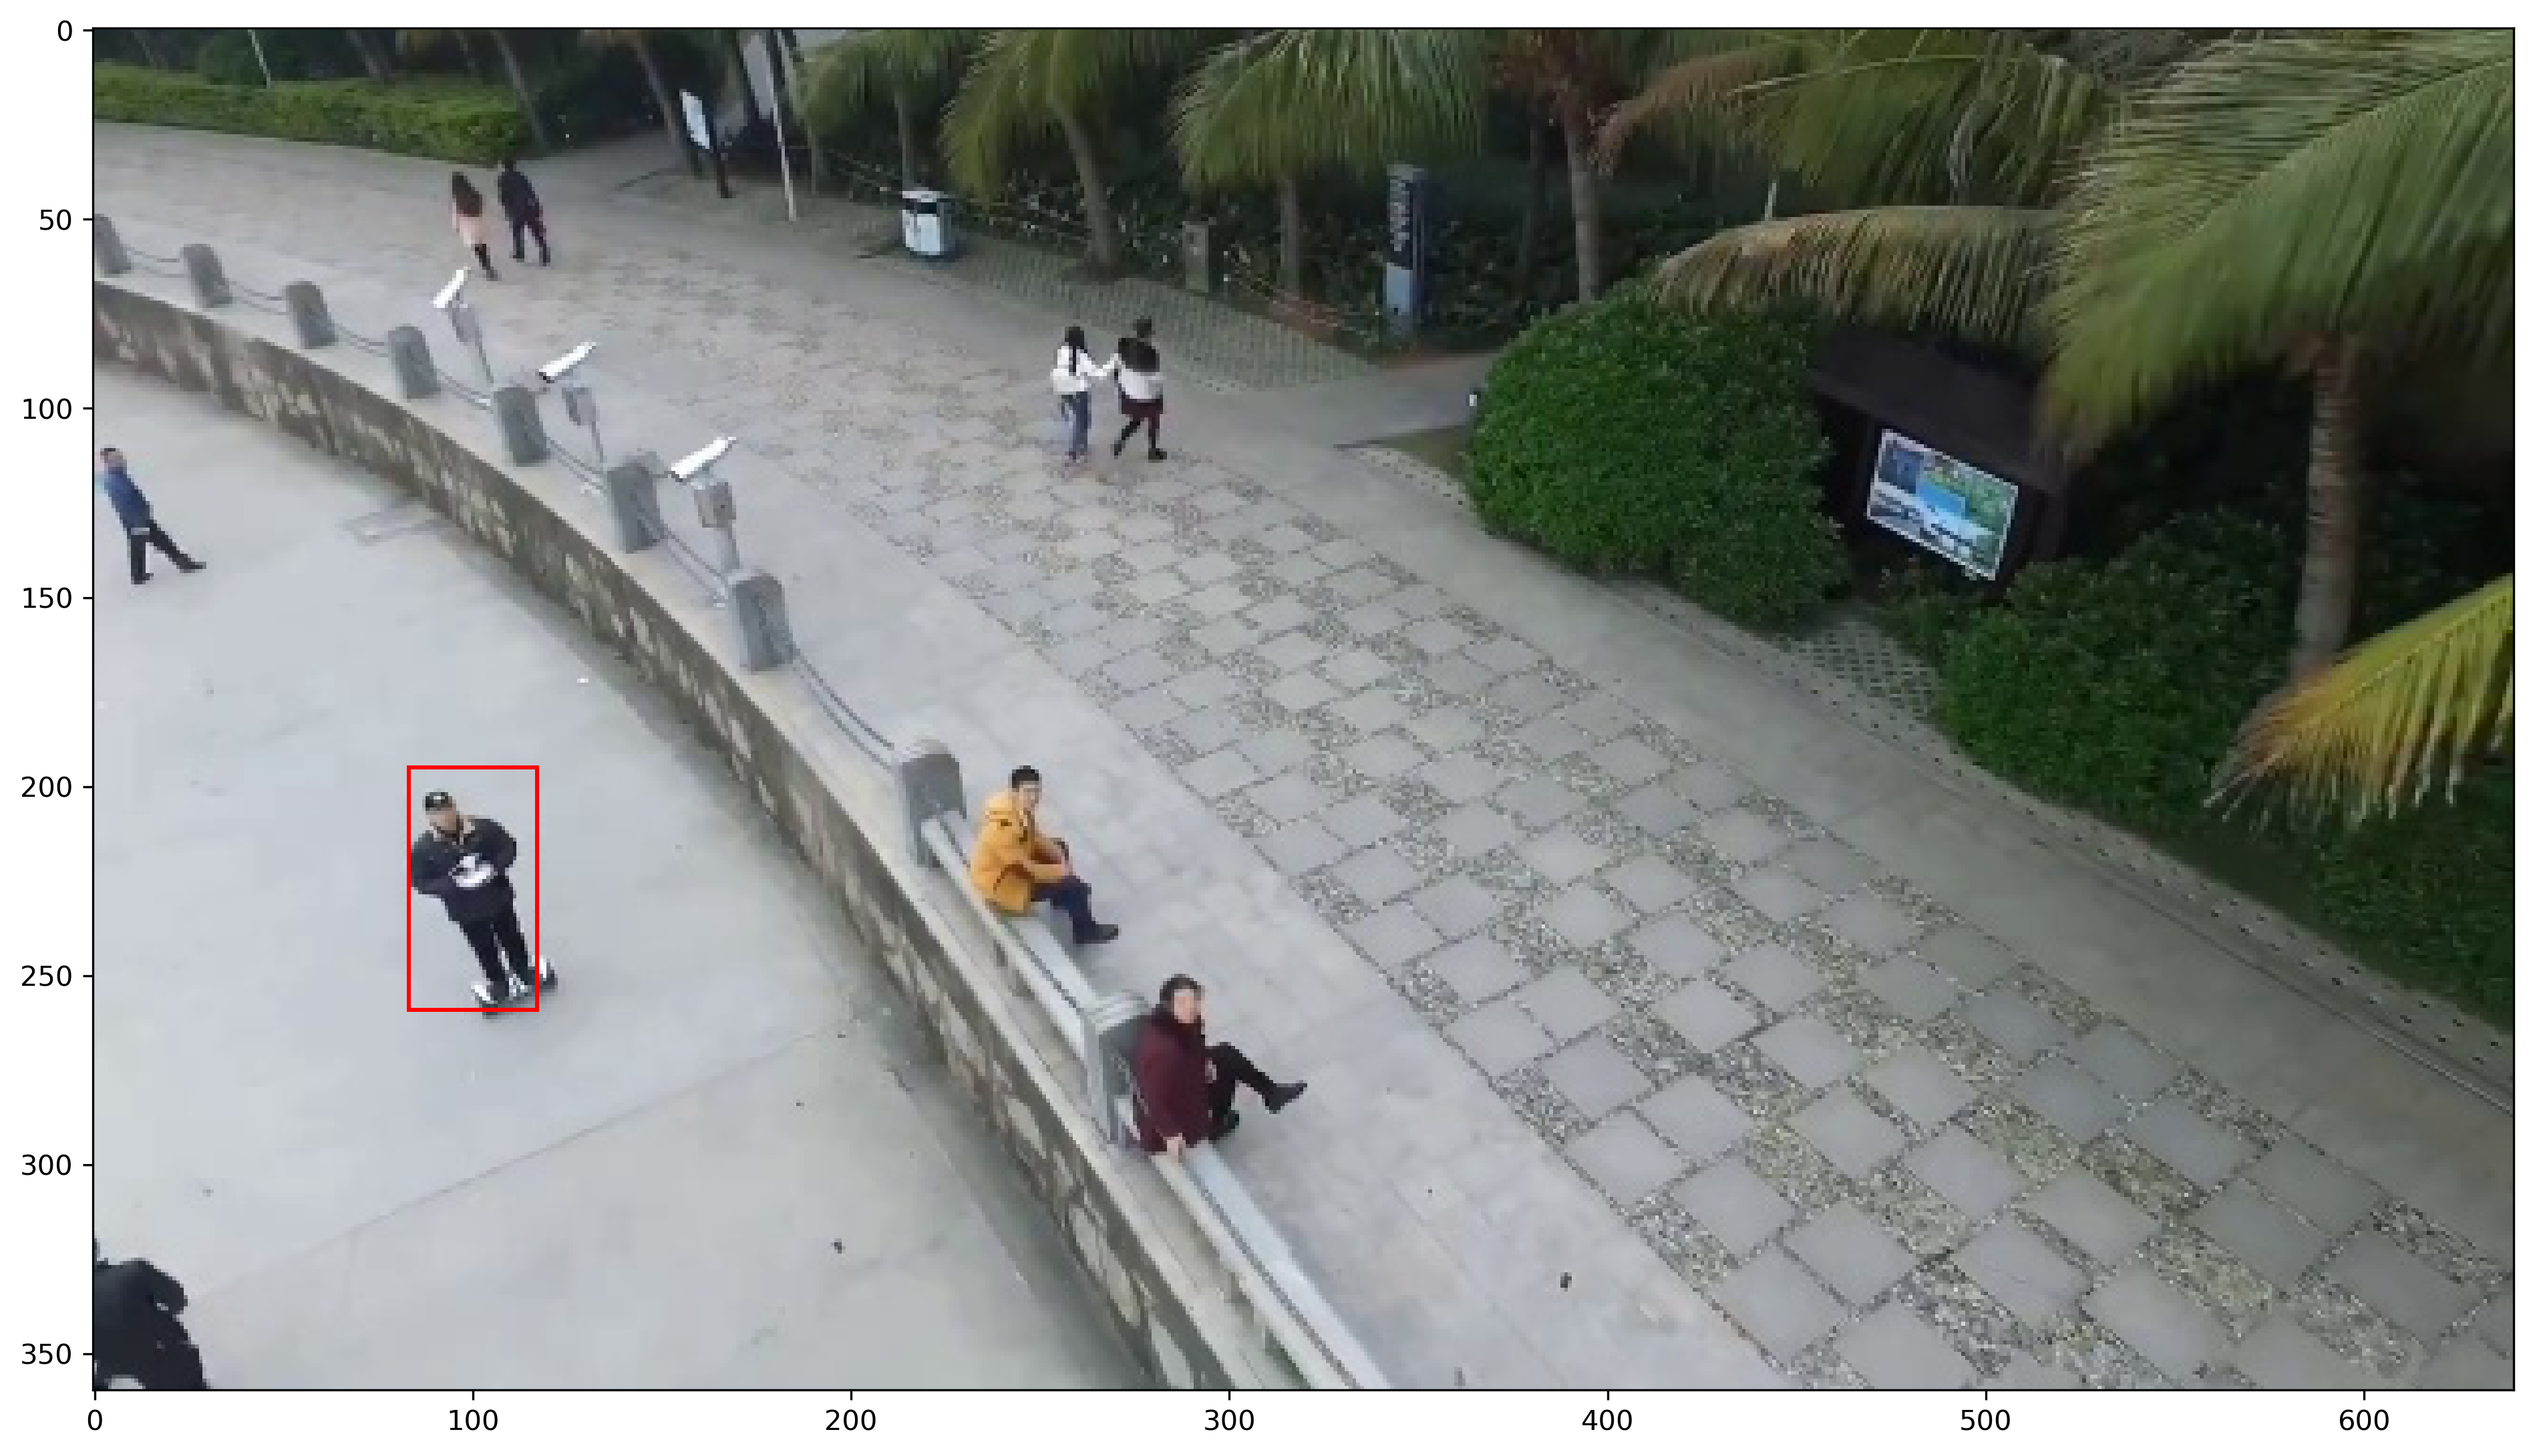

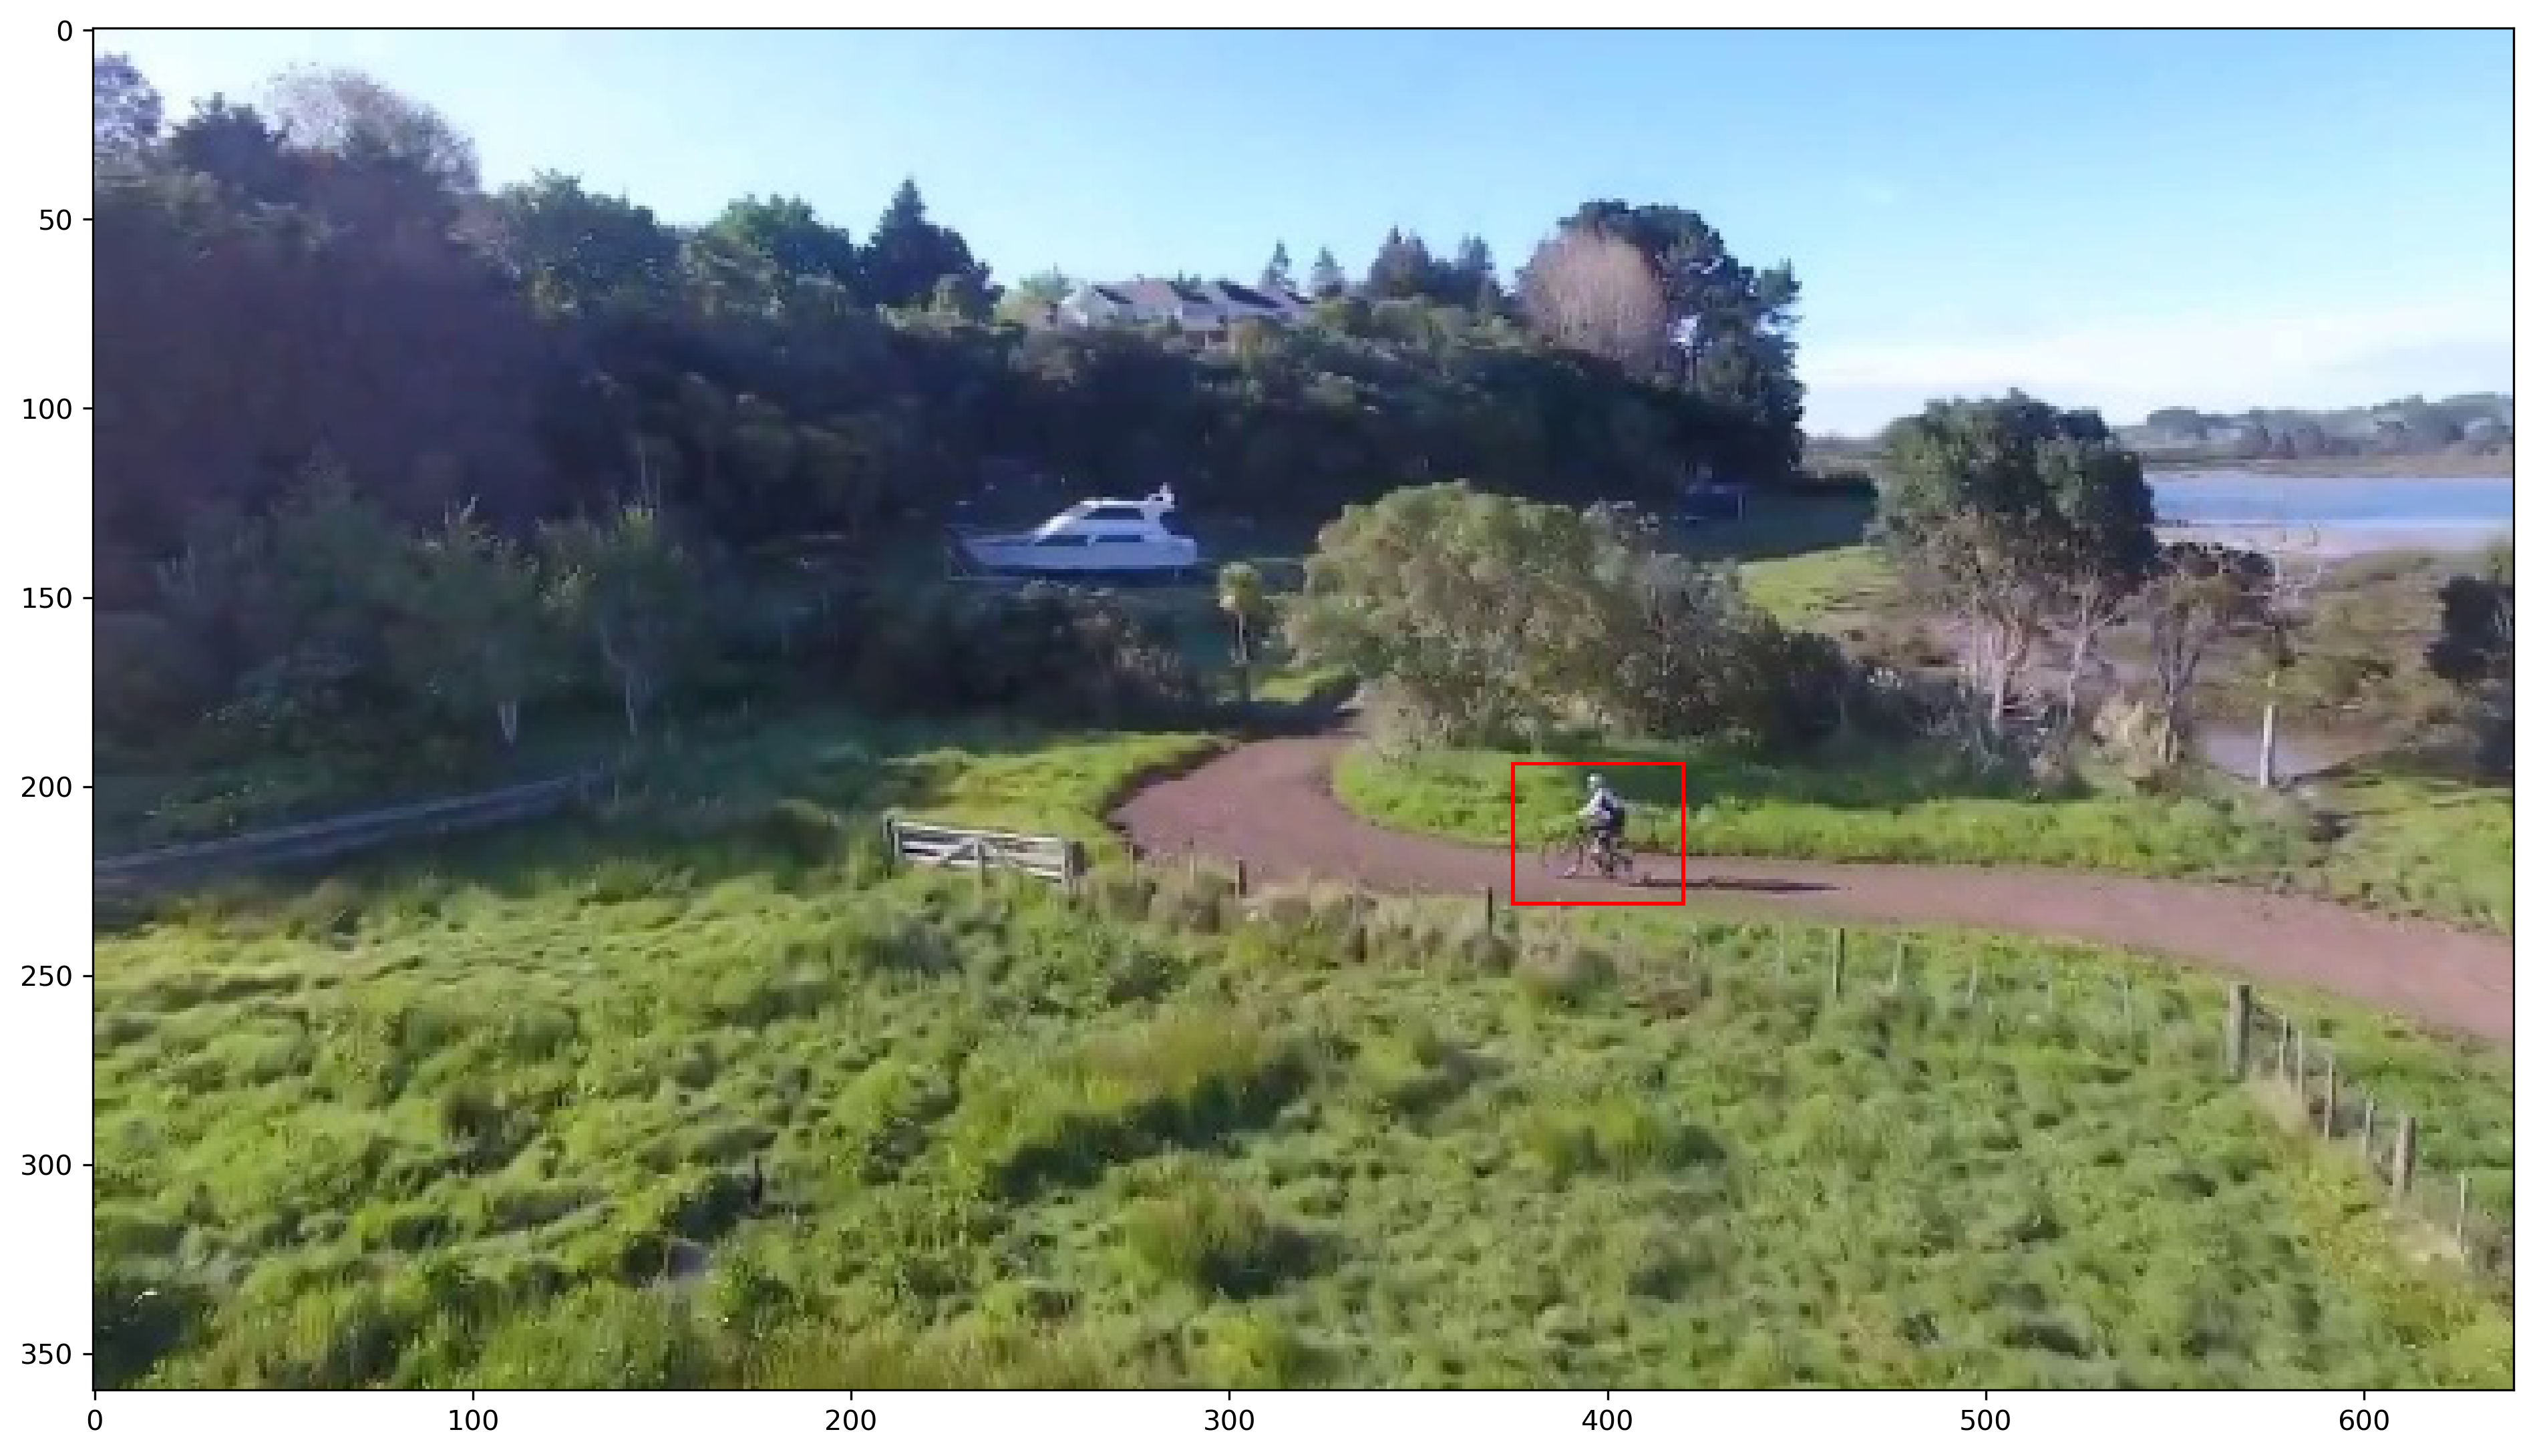

In [5]:
'''
Let's put aside 96 images for testing and 900 for training
'''
import random
random.shuffle(lines)

test_lines = lines[:96]
print('There are %d image-label pair in the testing set' %(len(test_lines)))
train_lines = lines[96:]
print('There are %d image-label pair in the training set' %(len(train_lines)))

test_images_paths = [line[0] for line in test_lines]
test_labels = [line[1] for line in test_lines]
train_images_paths = [line[0] for line in train_lines]
train_labels = [line[1] for line in train_lines]
print('First image in the testing set is: %s' %(test_images_paths[0]))
print('Corresponding box is: %s' %(test_labels[0]))

print('First image in the training set is: %s' %(train_images_paths[0]))
print('Corresponding box is: %s' %(train_labels[0]))

show_image(test_images_paths[0], test_labels[0])
show_image(train_images_paths[0], train_labels[0])

In [6]:
'''
Now import those images
'''

test_images = []
for image_path in test_images_paths:
    image = load_input(image_path)
    test_images.append(image)
test_images = np.array(test_images).reshape((96, 160, 320, 3))
test_labels = tf.convert_to_tensor(np.array(test_labels))
print(test_labels)
print(np.shape(test_images))
print(np.shape(test_labels))
    
train_images = []
for image_path in train_images_paths:
    image = load_input(image_path)
    train_images.append(image)
train_images = np.array(train_images).reshape((900, 160, 320, 3))
train_labels = tf.convert_to_tensor(np.array(train_labels))
print(train_labels)
print(np.shape(train_images))
print(np.shape(train_labels))

Tensor("Const:0", shape=(96, 4), dtype=float64)
(96, 160, 320, 3)
(96, 4)
Tensor("Const_1:0", shape=(900, 4), dtype=float64)
(900, 160, 320, 3)
(900, 4)


## section 1
First, a pre-defined keras model is given. Your task is to play with the training configurations and explore their effects on the training performance (speed, accuracy, etc.)

In [7]:
model = tf.keras.models.Sequential([
    #first dw-pw module
    layers.DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1, strides=(1,1), input_shape=(160, 320, 3)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    layers.Conv2D(16, (1, 1), padding='same', strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    
    #maxpooling
    layers.MaxPool2D(strides=(2, 2)),
    
    #second dw-pw module
    layers.DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1, strides=(1,1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    layers.Conv2D(32, (1, 1), padding='same', strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    
    #maxpooling
    layers.MaxPool2D(strides=(2, 2)),
    
    #third dw-pw module
    layers.DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1, strides=(1,1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    layers.Conv2D(64, (1,1), padding='same', strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    
    #maxpooling
    layers.MaxPool2D(strides =(2,2)),
    
    #fourth dw-pw module
    layers.DepthwiseConv2D((3, 3), padding='same', depth_multiplier=1, strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    layers.Conv2D(128, (1,1), padding='same', strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    
    #fifth dw-pw module
    layers.DepthwiseConv2D((3, 3),padding='same', depth_multiplier=1, strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    layers.Conv2D(256, (1, 1), padding='same', strides=(1, 1)),
    layers.BatchNormalization(momentum=0.1, epsilon=1e-5),
    layers.ReLU(6.0),
    
    #output
    layers.Conv2D(10,(1,1), padding='same', strides=(1, 1)),
    ]
)

W0805 18:07:22.214811 27072 deprecation.py:506] From C:\Users\Aperture\Anaconda3\envs\tf-gpu-pip\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Save the model to a checkpoint file. I choose not to use ```keras.save()``` because I think checkpoint give you more control when you deploy it. 

In [8]:
checkpoint_path = "keras_saves/cp_model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = [
    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=0),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=0)
]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
depthwise_conv2d (DepthwiseC (None, 160, 320, 3)       30        
_________________________________________________________________
batch_normalization (BatchNo (None, 160, 320, 3)       12        
_________________________________________________________________
re_lu (ReLU)                 (None, 160, 320, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 320, 16)      64        
_________________________________________________________________
batch_normalization_1 (Batch (None, 160, 320, 16)      64        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 160, 320, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 160, 16)       0

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def bbox_iou(boxA, boxB):
    x_a_ll = boxA[0] - boxA[2]/2
    y_a_ll = boxA[1] - boxA[3]/2
    x_a_ur = boxA[0] + boxA[2]/2
    y_a_ur = boxA[1] + boxA[3]/2
    x_b_ll = boxB[0] - boxB[2]/2
    y_b_ll = boxB[1] - boxB[3]/2
    x_b_ur = boxB[0] + boxB[2]/2
    y_b_ur = boxB[1] + boxB[3]/2
    xA = max(x_a_ll, x_b_ll)
    yA = max(y_a_ll, y_b_ll)
    xB = min(x_a_ur, x_b_ur)
    yB = min(y_a_ur, y_b_ur)
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = boxA[2]*boxA[3]
    boxBArea = boxB[2]*boxB[3]
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

def get_box(output):
    anchors = [1.4940052559648322, 2.3598481287086823, 4.0113013115312155, 5.760873975661669]
    h = output.shape[2]
    w = output.shape[3]
    output = output.reshape(2,5,800).transpose(1,0,2).flatten().reshape(5,1600)
    grid_x = np.tile(np.tile(np.linspace(0,w-1,w),h).reshape(h,w),(2,1,1)).flatten()
    grid_y = np.tile(np.tile(np.linspace(0,h-1,h),w).reshape(w,h).T,(2,1,1)).flatten()
    xs = sigmoid(output[0]) + grid_x
    ys = sigmoid(output[1]) + grid_y
    anchor_w = np.zeros(1600)
    anchor_h = np.zeros(1600)
    anchor_w[0:800] = anchors[0]
    anchor_w[800:1600] = anchors[2]
    anchor_h[0:800] = anchors[1]
    anchor_h[800:1600] = anchors[3]
    ws = np.exp(output[2]) * anchor_w
    hs = np.exp(output[3]) * anchor_h
    ind = np.argmax(output[4])
    bcx = xs[ind]
    bcy = ys[ind]
    bw = ws[ind]
    bh = hs[ind]
    box = [bcx/w, bcy/h, bw/w, bh/h]
    return box

def custom_loss(y_true, y_pred):
    anchors = [1.4940052559648322, 2.3598481287086823, 4.0113013115312155, 5.760873975661669]
    y_pred = tf.transpose(y_pred, (0, 3, 1, 2))
    print(np.shape(y_true))
    h = np.shape(y_pred)[2]
    w = np.shape(y_pred)[3]
    hf = tf.cast(h, dtype=tf.float32)
    wf = tf.cast(w, dtype=tf.float32)
    y_pred = tf.reshape(tf.reshape(tf.transpose(tf.reshape(y_pred, (2, 5, 800)), (1, 0, 2)), [-1]), (5, 1600))
    grid_x = tf.reshape(tf.tile(tf.reshape(tf.tile(tf.linspace(0.0, wf - 1.0, w), [h]), (h, w)), (2, 1)), [-1])
    grid_y = tf.reshape(tf.tile(tf.transpose(tf.reshape(tf.tile(tf.linspace(0.0, hf - 1.0, h), [w]), (w, h))), (2, 1)), [-1])
    xs = tf.sigmoid(y_pred[0]) + grid_x
    ys = tf.sigmoid(y_pred[1]) + grid_y
    anchor_w = np.zeros(1600)
    anchor_h = np.zeros(1600)
    anchor_w[0:800] = anchors[0]
    anchor_w[800:1600] = anchors[2]
    anchor_h[0:800] = anchors[1]
    anchor_h[800:1600] = anchors[3]
    ws = tf.exp(y_pred[2]) * anchor_w
    hs = tf.exp(y_pred[3]) * anchor_h
    ind = tf.argmax(y_pred[4])
    bcx = xs[ind]
    bcy = ys[ind]
    bw = ws[ind]
    bh = hs[ind]
    box = [np.divide(bcx, wf), tf.truediv(bcy, hf), tf.truediv(bw, wf), tf.truediv(bh,hf)]
    loss = tf.square(box[0] - y_true[0])
    return loss

# adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
model.compile(optimizer='adam', 
              loss=custom_loss,
              metrics=['accuracy'])


(?, ?, ?, ?)


In [10]:
time_s = time.perf_counter()
history = model.fit(
    train_images, 
    train_labels,
    batch_size = 1,
    steps_per_epoch = 360,
    epochs = 50,
    validation_split = 0.2,
    shuffle = True,
    callbacks = cp_callback)

test_loss, test_acc = model.evaluate(test_images, test_labels)
time_t = time.perf_counter()

Epoch 1/50


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[720,16,160,320] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[loss/mul/_335]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[720,16,160,320] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [ ]:
mins = int((time_t - time_s)/60)
secs = time_t - time_s - mins*60

print('Test accuracy:', test_acc)
print('Total Elapsed Time: %d mins %.2f secs' %(mins, secs))
predictions = model.predict(test_images)